<a href="https://colab.research.google.com/github/Hit07/ML-DL-Torch/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Neural Network

- Getting a vision dataset to work with using torchvision.datasets
- Architecture of a convolutional neural network (CNN) with PyTorch
- An end-to-end multi-class image classification problem
- Steps in modelling with CNNs in PyTorch
- Creating a CNN model with PyTorch
- Picking a loss and optimizer
- Training a model a model
- Evaluating a model


## 0. Computer vision libaries in PyTorch
*   [**torchvision**](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base
domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer
vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images)
to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

# Import Statemnents

In [1]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('skipped')
else:
  print(f'Downloaded')
  r = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  r.raise_for_status
  with open('helper_functions.py','wb') as file:
    file.write(r.content)

skipped


In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms # Converting images to tensors
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from helper_functions import accuracy_fn
from timeit import default_timer as timer



# Getting data

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

# Data Exploration

In [4]:
len(train_data),len(test_data)

(60000, 10000)

In [5]:
image,label = train_data[2]

class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx,train_data.targets

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 tensor([9, 0, 0,  ..., 3, 0, 5]))

In [7]:
image.shape,class_name[label]

(torch.Size([1, 28, 28]), 'T-shirt/top')

## Visulize the data


Text(0.5, 1.0, 'Ankle boot')

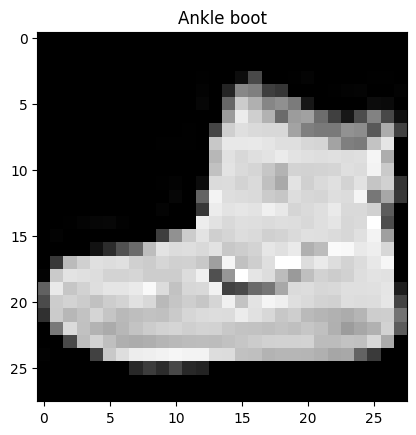

In [8]:
image,label = train_data[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_name[label])

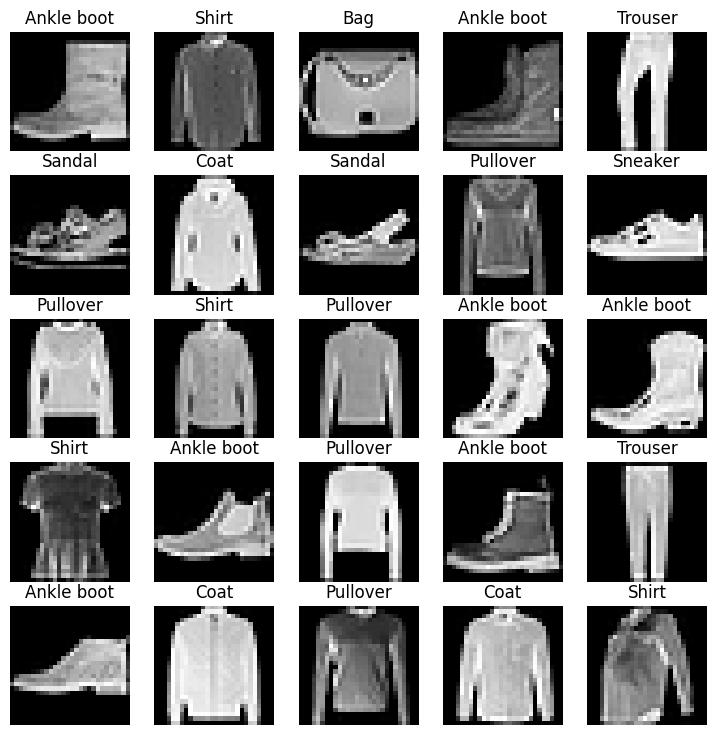

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 5,5
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)

## Prepare DataLoader
Right now, our data is in the form of PyTorch Datasets.
DataLoader turns our dataset into a Python iterable.
More specifically, we want to turn our data into batches (or mini-batches) •
Why would we do this?
1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32) •
2. It gives our neural network more chances to update its gradients per epoch.

In [10]:
# Creating batches of 32 samples  train(1875 batches) and test(313)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = 32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size = 32,
                              shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b2450c2ca90>,
 <torch.utils.data.dataloader.DataLoader at 0x7b2451d689a0>)

In [11]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 1, label size: torch.Size([])


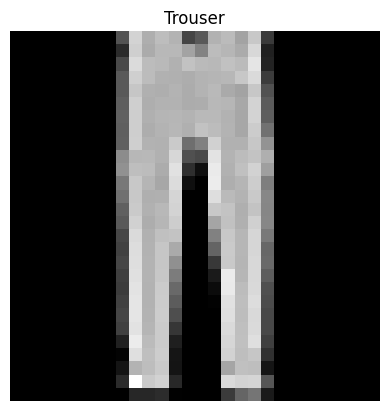

In [12]:
torch.manual_seed(42)
random_indx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_indx],train_labels_batch[random_indx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(class_name[label])
plt.axis (False)
print (f"Image size: {img.shape}" )
print(f"Label: {label}, label size: {label.shape}")

# Model 0: Building Model


In [13]:
flatten_model = nn.Flatten()
# Get a single sample
x = train_features_batch[0]
# Flatten the sample
output = flatten_model(x) # perform forward pass
# Print out what happened
print(f"Shape before flattening: {x.shape} →> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) →> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [14]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [15]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features=input_shape,out_features=hidden_units),
                                     nn.Linear(in_features=hidden_units,out_features=output_shape))

  def forward(self,x):
    return self.layer_stack(x)


torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(train_data.classes)).to('cpu')
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
# Loss Fuction and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

### Create function to time our experiments

Machine learning is very experimental.
Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [17]:
def print_train_time(start:float,end:float,device:torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time: 3f} seconds")
  return total_time

In [18]:
start_time = timer()
####
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cuda" )

Train time on cuda:  0.000053 seconds


5.294399988997611e-05

## Creating a training loop and training a model on batches of data
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it .

In [19]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
import torch
from timeit import default_timer as timer

# Set random seed for reproducibility
torch.manual_seed(42)

train_time_start_cpu = timer()

epochs = 4
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        model_0.train()
        # Calculate loss per batch
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # accumulate loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch % 400 == 0:
            print(f'Done with batch samples: {batch * len(X)}/{len(train_dataloader.dataset)}')

    train_loss /= len(train_dataloader)  # average

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f'\nTrain loss: {train_loss:.4f} Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.5904 Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4763 Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4550 Test loss: 0.4766, Test acc: 83.4265
Epoch: 3
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4425 Test loss: 0.4631, Test acc: 83.7460
Train time o

## Make predictions and get Model_0 results

In [20]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  ''' Return a dictionary containing the results of model predicting on data_loader.'''
  loss,acc=0,0
  # model.to(device)  # Move the model to the correct device
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # X,y = X.to(device),y.to(device)
      y_predic = model(X)
      loss += loss_fn(y_predic,y)
      acc += accuracy_fn(y,y_predic.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return{
      'model_name':model.__class__.__name__, # works if it is created with class
      'model_loss':f'{loss.item():.4f}',
      'model_acc': f'{acc:.2f}%'}


# Calculate model 0 results on test dataset

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': '0.4631',
 'model_acc': '83.75%'}

# Improving the Model(Change the device to run on GPU)

In [21]:
class FashionModelV1(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_stack  = nn.Sequential(nn.Flatten(),
                                      nn.Linear(in_features = input_shape,out_features=hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features=hidden_units,out_features=output_shape),
                                      nn.ReLU())
  def forward(self,x):
    return self.layer_stack(x)

# Random_seed
torch.manual_seed(42)
#Instantiate
model_1 = FashionModelV1(input_shape=784,
                         output_shape=len(train_data.classes),
                         hidden_units=10).to('cpu')
next(model_1.parameters()).device

device(type='cpu')

In [22]:
# Loss func and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_1.parameters(),lr=0.1)


In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = 'cpu'):
    """Performs a training step with the model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Move data to the same device as the model
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.3f}%')


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = 'cpu'):
    """Performs a testing step with the model evaluating on data_loader."""
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Move data to the same device as the model
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f'\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.3f}%')

In [24]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model_1.to(device)

epochs = 3
start_time = timer()

# Training loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_step(model_1,
               train_dataloader,
               loss_fn,
               optimiser,
               accuracy_fn,
               device)

    # Test Loop
    test_step(model_1,
              test_dataloader,
              loss_fn,
              accuracy_fn,
              device)

end_time = timer()

total_train_time = print_train_time(start_time, end_time, str(next(model_1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Train loss: 1.0920 | Train acc: 61.343%

Test loss: 0.9564 | Test acc: 64.996%
Epoch: 1

Train loss: 0.7810 | Train acc: 71.928%

Test loss: 0.7223 | Test acc: 73.912%
Epoch: 2

Train loss: 0.6703 | Train acc: 75.937%

Test loss: 0.6850 | Test acc: 75.020%
Train time on cpu:  35.313944 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
> Why is this?
> 1. It could be that the overhead for copying data/model to and from the GPU
outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms compute capability than
the GPU.

In [25]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results,model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionModelV1',
  'model_loss': '0.6850',
  'model_acc': '75.02%'},
 {'model_name': 'FashionMNISTModelV0',
  'model_loss': '0.4631',
  'model_acc': '83.75%'})

# Model 2: Building a Convolutional Neural Network (CNN)

[Model Build from this<---](https://poloclub.github.io/cnn-explainer/)
CNN's are also known ConvNets.
CNN's are known for their capabilities to find patterns in visual data

In [26]:
# CNN
class FashionMNISTModelV2(nn.Module):
  ''' Model architecture that replicates the TinyVGG
  model from CNN explainer website '''

  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # Imp:
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x




In [27]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)


In [28]:

len(class_name)

10

In [29]:
# Example to under what to mul with the hidden_units as in_features
random_image = torch.randn(size=(1,28,28))
# model_2(random_image)

In [30]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [31]:
# Training and Testing

torch.manual_seed(42)
epochs = 3


start_time_v2 = timer()
for epoch in tqdm(range(epochs)):
  print(f'Epochs: {epoch}')

  train_step(model_2,train_dataloader,loss_fn,optimiser,accuracy_fn,device)
  test_step(model_2,train_dataloader,loss_fn,accuracy_fn,device)

end_time_v2 = timer()

total_time_V2 = print_train_time(start_time_v2,end_time_v2,str(next(model_2.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 0

Train loss: 0.5952 | Train acc: 78.375%

Test loss: 0.3707 | Test acc: 86.777%
Epochs: 1

Train loss: 0.3642 | Train acc: 86.857%

Test loss: 0.3610 | Test acc: 87.548%
Epochs: 2

Train loss: 0.3247 | Train acc: 88.307%

Test loss: 0.3195 | Test acc: 88.653%
Train time on cpu:  226.258095 seconds


In [32]:
model_2_results = eval_model(model_2,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': '0.3494',
 'model_acc': '87.46%'}

In [120]:
import pandas as pd
comparing_model_results = pd.DataFrame([model_0_results,
                                        model_1_results,
                                        model_2_results])
comparing_model_results


,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.4631,83.75%
1,FashionModelV1,0.6850,75.02%
2,FashionMNISTModelV2,0.3494,87.46%


In [121]:
comparing_model_results['training_time'] = [total_train_time_model_0,
                                            total_train_time,
                                            total_time_V2]

In [122]:
comparing_model_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.4631,83.75%,59.421061
1,FashionModelV1,0.6850,75.02%,35.313944
2,FashionMNISTModelV2,0.3494,87.46%,226.258095


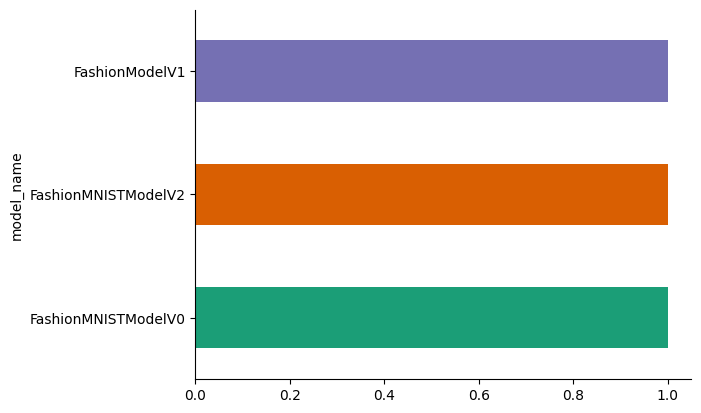

In [36]:
# @title model_name

from matplotlib import pyplot as plt
import seaborn as sns
comparing_model_results.groupby('model_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Evaluating and Testing

In [37]:
def make_predictions (model: torch.nn.Module,
                      data: list,
                      device: torch.device = device):
    model.eval()
    with torch.no_grad():
        data = torch.stack(data).to(device)
        output = model(data)
        return torch.softmax(output, dim=1)


In [38]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [39]:
import random
# torch.manual_seed(42)
test_labels = []
test_samples = []
for sample,label in random.sample(list(test_data),k=9):
  test_labels.append(label)
  test_samples.append(sample)

len(test_labels)

9

Text(0.5, 1.0, 'Trouser')

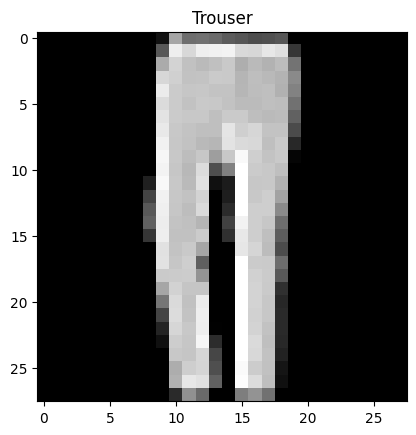

In [40]:
plt.imshow(test_samples[0].squeeze(),cmap='gray')
plt.title(class_name[test_labels[0]])

In [41]:
# Make prediction probabilities

pred_probs = make_predictions(model=model_2,
                             data=test_samples,
                              device=device)
pred_probs

tensor([[8.1239e-06, 9.9677e-01, 1.9692e-07, 3.1993e-03, 6.0289e-06, 2.1661e-06,
         7.9066e-06, 1.8996e-06, 7.3935e-06, 4.4694e-07],
        [1.3826e-05, 9.9101e-01, 5.5745e-07, 8.9242e-03, 8.8410e-06, 1.3327e-06,
         1.2822e-05, 8.1697e-06, 1.2728e-05, 1.1272e-05],
        [8.6921e-06, 4.0002e-06, 3.7488e-06, 5.8614e-07, 1.0477e-06, 1.3189e-03,
         1.0801e-06, 9.7278e-01, 1.0435e-04, 2.5775e-02],
        [1.8500e-05, 1.5516e-06, 5.1081e-05, 1.9247e-03, 1.0510e-04, 5.5746e-02,
         1.3889e-05, 2.2223e-04, 9.4186e-01, 5.7020e-05],
        [5.8270e-04, 6.0926e-05, 9.6830e-01, 1.3542e-03, 1.5864e-02, 1.4642e-06,
         1.3668e-02, 1.6410e-06, 1.6965e-04, 1.9333e-06],
        [1.2411e-03, 6.2036e-04, 1.3073e-01, 4.0072e-05, 6.2224e-01, 7.6375e-05,
         2.4290e-01, 3.2334e-05, 2.0466e-03, 6.9054e-05],
        [1.1528e-03, 1.1977e-03, 1.7213e-01, 1.0754e-05, 8.0154e-01, 7.9745e-05,
         2.1463e-02, 9.2843e-05, 2.2714e-03, 5.8835e-05],
        [4.9515e-07, 5.4372

In [42]:
# Prediction Labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 1, 7, 8, 2, 4, 4, 7, 3])

(-0.5, 27.5, 27.5, -0.5)

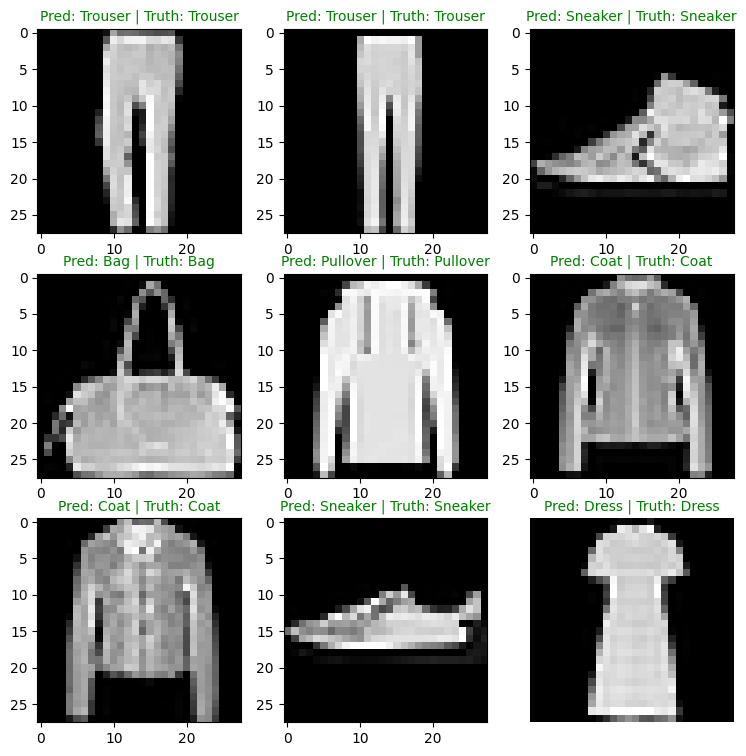

In [43]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate (test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)
  # Plot the target image
  plt.imshow (sample.squeeze(), cmap="gray")
  # Find the prediction (in text form, e.g "Sandal" )
  pred_label = class_name[pred_classes[i]]
  # Get the truth label (in text form)
  truth_label = class_name[test_labels[i]]
  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")
plt.axis(False)



# Making a confusion matrix for further prediction evaluation
A confusion matrix is a fantastic way of evaluating your classification models visually: https://www.learnpytorch.io/02_pytorch_classification9-more-classification-evaluation-metrics
1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix` - https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
3. Plot the confusion matrix using `mixtend.plotting.plot_confusion_matrix()`- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusionmatrix/

In [53]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch. inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    x, y = x. to (device), y. to (device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities →> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation

    y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    # print(y_preds)
    y_pred_tensor = torch.cat(y_preds)

y_pred_tensor


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [47]:
len(y_pred_tensor)

10000

In [45]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics,mlxtend
  print(f"mlxtend version: {mlxtend.__version_  }")
  assert int(mlxtend._version_split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics,mlxtend
  print(f"mlxtend version:{mlxtend.__version__}" )

mlxtend version:0.23.1


In [50]:
import mlxtend

mlxtend.__version__

'0.23.1'

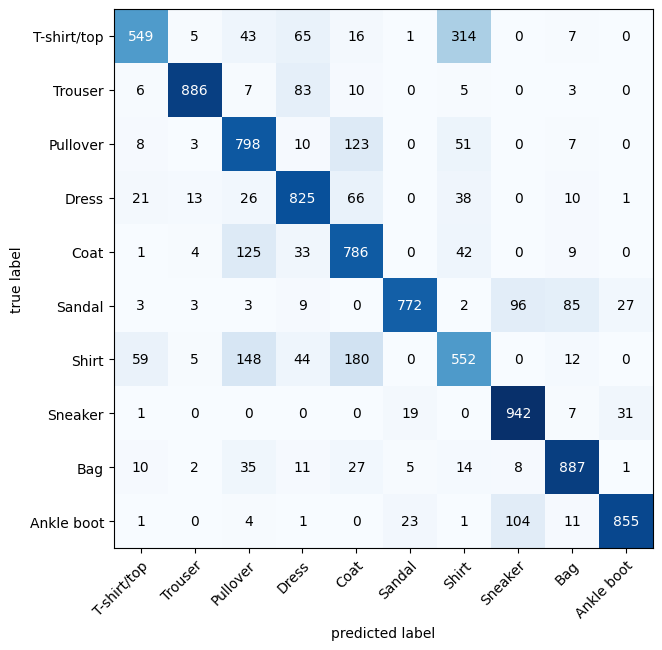

In [57]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_name),task='MULTICLASS')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets, # labels
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(10,7)
)

# Save and Load best performing model

In [61]:
from pathlib import Path


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME = 'FashionMNISTV2.plt'
MODEL_SAVE_PATH =  MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

torch.save(model_2.state_dict(),MODEL_SAVE_PATH)

In [65]:

torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(1,10,10)
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [66]:
loaded_model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [98]:
torch.manual_seed(42)
epochs=3
start_time_load = timer()
for epoch in tqdm(range(epochs)):
  print(f'Epochs: {epochs}')
  train_step(loaded_model_2,test_dataloader,loss_fn,optimiser,accuracy_fn)
  test_step(loaded_model_2,test_dataloader,loss_fn,accuracy_fn)
  end_time_load = timer()

total_time = print_train_time(start_time_load,end_time_load,str(next(loaded_model_2.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 3

Train loss: 0.3494 | Train acc: 87.460%

Test loss: 0.3494 | Test acc: 87.460%
Epochs: 3

Train loss: 0.3494 | Train acc: 87.460%

Test loss: 0.3494 | Test acc: 87.460%
Epochs: 3

Train loss: 0.3494 | Train acc: 87.460%

Test loss: 0.3494 | Test acc: 87.460%
Train time on cpu:  39.012806 seconds


In [74]:
load_model_2_results = eval_model(loaded_model_2,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn)
load_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': '0.3494',
 'model_acc': '87.46%'}

In [123]:
comparing_model_results.loc[len(comparing_model_results)] = load_model_2_results

# comparing_model_results.loc[len(comparing_model_results)]['training_time'] = total_time


In [124]:
comparing_model_results
comparing_model_results.at[len(comparing_model_results)-1,'training_time'] = total_time

In [125]:
comparing_model_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.4631,83.75%,59.421061
1,FashionModelV1,0.6850,75.02%,35.313944
2,FashionMNISTModelV2,0.3494,87.46%,226.258095
3,FashionMNISTModelV2,0.3494,87.46%,39.012806
